In [1]:
from math import gamma, e
import numpy as np
import matplotlib.pyplot as plt

def upper_incomplete_gamma(a, x, iterations):
    """
    Implementation for upper incomplete gamma.
    """
    val = 1.0
    for d in reversed(range(1, iterations)):
        val = d * 2 - 1 - a + x + (d * (a - d)) / val
    return ((x ** a) * (e ** (-x))) / val

def chi2cdf(x, df, iterations=100):
    """
    Chi squared cdf function. This function can also be used from scipy,
    but to reduce the compilation size a seperate (slighty slower)
    implementation without scipy is written.
    """
    return 1 - upper_incomplete_gamma(0.5 * df, 0.5 * x, iterations) / gamma(0.5 * df)


In [3]:
cdfvals = [
    0.7654882799541598,
    0.4999999999999998,
    0.015950051932194214,
    0.9999992505029532,
    0.6080113617889948,
    0.5945427228024227,
    0.9672674432700619,
    0.06512443401321769,
    0.03461583176177169,
    0.9999961618213578,
    0.9999998301250765,
    0.9999961618213578,
    0.9997373509493863,
    0.9950331497314754,
    0.9997373509493863,
]

# cdfvals = [
#     0.7654882799541598,
#     0.4999999999999998,
#     0.015950051932194214,
#     0.9999992505029532,
#     0.6080113617889948,
#     0.5945427228024227,
#     0.9672674432700619,
#     0.06512443401321769,
#     0.03461583176177169,
#     0.3999961618213578,
#     0.3999998301250765,
#     0.3999961618213578,
#     0.3997373509493863,
#     0.3950331497314754,
#     0.9997373509493863,
# ]

# cdfvals = np.r_[np.random.rand(10)  * 0.1, 0.2 + np.random.rand(10)  * 0.8, 1 - np.random.rand(10) * 0.3]
# cdfvals = np.random.beta(a=0.8, b=0.8, size=50)
# cdfvals = np.random.rand(100)
# cdfvals = np.linspace(0.025, 0.975, 20)

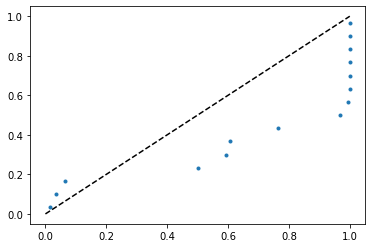

In [4]:
fig, ax = plt.subplots()
ranks = (np.argsort(np.argsort(cdfvals))+0.5) / len(cdfvals)
ax.plot(cdfvals, ranks, marker='.', ls='')
ax.plot([0, 1], [0, 1], color='k', ls='--')

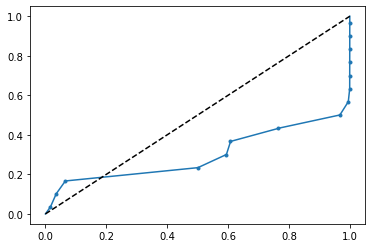

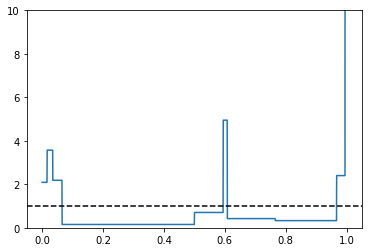

In [5]:
x = np.concatenate(([0], np.sort(cdfvals), [1]))
y = np.concatenate(([0], np.sort(ranks), [1]))

xgrid = np.linspace(0, 1, 10000)
y_interp = np.interp(xgrid, x, y)

fig, ax = plt.subplots()
ax.plot(xgrid, y_interp)
ax.plot(cdfvals, ranks, marker='.', ls='', color='C0')
ax.plot([0, 1], [0, 1], color='k', ls='--')

fig, ax = plt.subplots()
ax.plot(xgrid, np.gradient(y_interp, xgrid))
ax.set_ylim(0, 10)
ax.axhline(1.0, ls='--', color='k')
# ax.plot(cdfvals, ranks, marker='.', ls='', color='C0')
# ax.plot([0, 1], [0, 1], color='k', ls='--')

In [6]:
for steps in [3, 5, 9, 11, 15, 21]:
    quantiles = np.linspace(0.05, 0.95, steps)
    s = dict(zip(*np.unique(np.digitize(cdfvals, quantiles), return_counts=True)))
    s = np.array([s[i] / len(cdfvals) if i in s else 0 for i in range(len(quantiles)+1)])
    p = np.diff(np.concatenate([[0], quantiles, [1]]))
    idx = s > 0.0
    MI = np.sum(s[idx] * np.log(s[idx] / p[idx]))
    print(steps, MI, 1- chi2cdf(x=2 * len(cdfvals) * MI, df=len(s)-1))
    

3 1.0688710747852272 5.068175458200486e-07
5 1.0801976772382538 4.936858053472548e-06
9 1.3112467374249022 1.001353133689431e-05
11 1.3856279211963056 1.9229779864460284e-05
15 1.4977853334033764 7.844319261296473e-05
21 1.616676981382954 0.0005875709797231732


In [72]:
from scipy.stats import cramervonmises, anderson, kstest, norm
from scipy.interpolate import interp1d
from tqdm.auto import tqdm

steps = 3
N = 20
# Too certain
# cdfvals = np.random.beta(a=0.5, b=0.5, size=N)
# Too uncertain
# cdfvals = np.random.beta(a=2, b=2, size=N)
# Perfect
cdfvals = np.random.rand(N)
# Skewed left

cali_cookes = []
cali_dfN = []
cali_dfbins = []
cali_CVM = []
cali_AD = []
cali_KS = []

quantiles = np.linspace(0.05, 0.95, steps)
npoints = list(range(2, N))

allvals = []

for j in tqdm(range(100)):
    
    cdfvals = np.random.beta(a=1, b=1.2, size=N)
    allvals.append(cdfvals)
#     cdfvals = np.random.beta(a=1, b=1, size=N)
    ranks = (np.argsort(np.argsort(cdfvals))+0.5) / len(cdfvals)

    cali_cookes.append([])
    cali_dfN.append([])
    cali_dfbins.append([])
    cali_CVM.append([])
    cali_AD.append([])
    cali_KS.append([])
    
    for i in npoints:
        vals = cdfvals[:i]
        rs = (np.argsort(np.argsort(vals))+0.5) / len(vals)

    #     print('====\n',i)

        s = dict(zip(*np.unique(np.digitize(vals, quantiles), return_counts=True)))
        s = np.array([s[i] / len(vals) if i in s else 0 for i in range(len(quantiles)+1)])
        p = np.diff(np.concatenate([[0], quantiles, [1]]))
        idx = s > 0.0
        MI = np.sum(s[idx] * np.log(s[idx] / p[idx]))
        c = 1- chi2cdf(x=2 * len(vals) * MI, df=len(s)-1)
    #     print(MI, )
        cali_cookes[j].append(c)
    #     print('-')

        s = np.diff(np.concatenate(([0], np.sort(vals), [1])))
        p = np.diff(np.concatenate(([0], np.sort(rs), [1])))
        idx = s > 0.0
        MI = np.sum(s[idx] * np.log(s[idx] / p[idx]))
        c1 = 1- chi2cdf(x=2 * len(vals) * MI, df=len(quantiles))
        cali_dfbins[j].append(c1)
        c2 = 1- chi2cdf(x=2 * len(vals) * MI, df=len(s)-1)
    #     c = cramervonmises(vals, cdf='uniform').pvalue
        cali_dfN[j].append(c2)

        c3 = cramervonmises(vals, cdf='uniform').pvalue
        cali_CVM[j].append(c3)

    #     c4 = anderson(norm.ppf(vals), dist='norm')
    #     c4 = np.interp(c4.statistic, c4.critical_values, c4.significance_level) / 100
    #     cali_AD.append(c4)

        c5 = kstest(vals, cdf='uniform').pvalue
        cali_KS[j].append(c5)
    
#     print(MI, 1- chi2cdf(x=2 * len(vals) * MI, df=len(quantiles)))
#     print(MI, 1- chi2cdf(x=2 * len(vals) * MI, df=len(s)-1))


  0%|          | 0/100 [00:00<?, ?it/s]

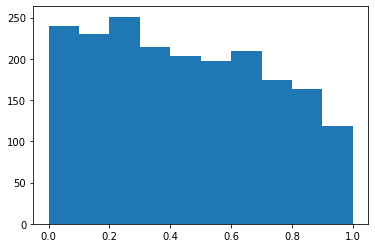

In [73]:
plt.hist(np.ravel(allvals));

(0.0, 1.0)

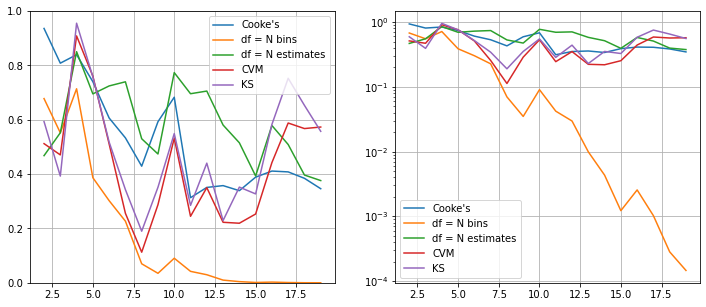

In [74]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
i = 0
for ax in axs:
    ax.plot(npoints, cali_cookes[i], label='Cooke\'s')
    ax.plot(npoints, cali_dfbins[i], label='df = N bins')
    ax.plot(npoints, cali_dfN[i], label='df = N estimates')
    ax.plot(npoints, cali_CVM[i], label='CVM')
    ax.plot(npoints, cali_KS[i], label='KS')
    ax.legend()
    ax.grid()
axs[1].set_yscale('log')
axs[0].set_ylim(0, 1)
# axs[1].set_ylim(1e-10, 1)

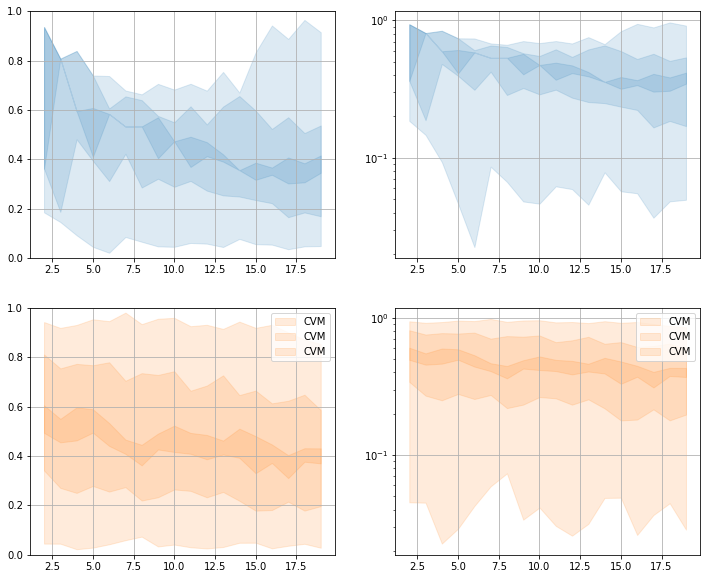

In [75]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 10), nrows=2)

for ax in axs[0]:
    ax.fill_between(npoints, *np.percentile(cali_cookes, [5, 95], axis=0), alpha=0.15, label='Cooke\'s', color='C0')
    ax.fill_between(npoints, *np.percentile(cali_cookes, [25, 75], axis=0), alpha=0.15, label='Cooke\'s', color='C0')
    ax.fill_between(npoints, *np.percentile(cali_cookes, [45, 55], axis=0), alpha=0.15, label='Cooke\'s', color='C0')
    ax.grid()
#     ax.fill_between(npoints, *np.percentile(cali_dfbins, [5, 95], axis=0), alpha=0.15, label='df = N bins')
#     ax.fill_between(npoints, *np.percentile(cali_dfN, [5, 95], axis=0), alpha=0.15, label='df = N estimates')
for ax in axs[1]:
    ax.fill_between(npoints, *np.percentile(cali_CVM, [5, 95], axis=0), alpha=0.15, label='CVM', color='C1')
    ax.fill_between(npoints, *np.percentile(cali_CVM, [25, 75], axis=0), alpha=0.15, label='CVM', color='C1')
    ax.fill_between(npoints, *np.percentile(cali_CVM, [45, 55], axis=0), alpha=0.15, label='CVM', color='C1')
#     ax.fill_between(npoints, *np.percentile(cali_KS, [5, 95], axis=0), alpha=0.15, label='KS')
    ax.legend()
    ax.grid()

# axs[1].set_yscale('log')
for ax in axs[:, 0]:
    ax.set_ylim(0, 1)
for ax in axs[:, 1]:
    ax.set_yscale('log')


    # axs[0]

In [249]:
np.percentile(cali_cookes, [0.05, 0.95], axis=0)

array([0.0001321 , 0.00074989, 0.0007708 , 0.00201475, 0.00448878,
       0.00638448, 0.00845855, 0.00962608, 0.01519846, 0.01107463,
       0.00363883, 0.00814717, 0.01185894, 0.00947758, 0.01071399,
       0.00053058, 0.0146653 , 0.01213362, 0.00648755, 0.00643235])

In [95]:
MI = np.sum(p[idx] * np.log(p[idx] / s[idx]))
print(MI, 1- chi2cdf(x=2 * len(cdfvals) * MI, df=len(quantiles)))
print(MI, 1- chi2cdf(x=2 * len(cdfvals) * MI, df=len(s)-1))


1.1295305146149743 0.0
1.1295305146149743 5.838472310060183e-07


In [19]:
dp = np.interp(np.r_[0, np.cumsum(p)], y_interp, xgrid)
dp = np.diff(dp)

idx = dp > 0
MI = np.sum(dp[idx] * np.log(dp[idx] / p[idx]))
print(MI, 1- chi2cdf(x=2 * len(cdfvals) * MI, df=len(quantiles)))
print(MI, 1- chi2cdf(x=2 * len(cdfvals) * MI, df=len(s)-1))

1.0871743861257086 3.8823430659196134e-07
1.0871743861257086 0.005303863810208087


In [418]:
fx = np.gradient(y_interp, xgrid)
dx = (xgrid[1] - xgrid[0])
- np.sum( fx * np.log(fx) * dx)

-2.264262563933586

In [378]:
- np.log(2)

-0.6931471805599453

C:\Users\Rongen\AppData\Local\Temp\ipykernel_17600\1097295558.py:3: RuntimeWarning: divide by zero encountered in true_divide
  ax.bar(x=(pos[1:] + pos[:-1])/2, height=np.nan_to_num(p/s, posinf=0), width=np.diff(pos), lw=1, facecolor='None', edgecolor='C0')


(0.0, 10.0)

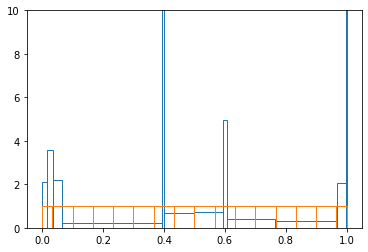

In [302]:
fig, ax = plt.subplots()
pos = np.concatenate(([0], np.sort(cdfvals), [1]))
ax.bar(x=(pos[1:] + pos[:-1])/2, height=np.nan_to_num(p/s, posinf=0), width=np.diff(pos), lw=1, facecolor='None', edgecolor='C0')

pos = np.concatenate(([0], np.sort(ranks), [1]))
ax.bar(x=(pos[1:] + pos[:-1])/2, height=1, width=np.diff(pos), lw=1, facecolor='None', edgecolor='C1')
ax.set_ylim(0, 10)

C:\Users\Rongen\AppData\Local\Temp\ipykernel_17600\1171321544.py:1: RuntimeWarning: divide by zero encountered in true_divide
  np.nan_to_num(p/s, posinf=0)


array([2.08985735e+00, 3.57159825e+00, 2.18517604e+00, 1.53300557e-01,
       7.05148579e-01, 4.94977011e+00, 4.23342465e-01, 3.30394207e-01,
       2.40104342e+00, 1.41717294e+01, 0.00000000e+00, 2.57588355e+02,
       0.00000000e+00, 2.15841823e+04, 1.15017464e+05, 1.96222801e+05])

In [37]:
Nmin = 15
calpower = 1
MI = np.sum(s[idx] * np.log(s[idx] / p[idx]))
E = 2 * Nmin * MI * calpower
# Test with chi squared
1 - chi2cdf(x=E, df=len(s) - 1)

0.005251194625496058